# Reinforcement Learning

## Multi-Armed Bandits

**Acknowledgement**: This presentation is borrowed from Tim Miller's website [Mastering Reinforcement Learning](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html).

### Definition
A multi-armed bandit is defined by a set of random variables $X_{i,k}$ where: (i) $i\in\{1,2,..,N\}$ is the arm of the bandit; (ii) $k$ is the index of the play.

Draws are independently distributed and the gambler does not know the probability distributions of the random variables. The gambler plays succesive rounds, observes the reward from the selected arm after each round, and then adjusts her strategy with the objective of maximizing the rewards collected over all rounds.

### Q-Value

The **Q-value** of an action is defined as the **expected reward** for taking action $a$, i.e. $Q(a) = \mathbb{E}[R | A = a]$. The true Q-value being unknown, it must be estimated. In practice, one can use the sample average of observed rewards to estimate the Q-value:

\begin{align*}
Q(a) = \frac{1}{N(a)} \sum_{i=1}^{t} X_{\{a,i\}},
\end{align*}
where $t$ is the number of rounds so far, $N(a)$ is the number of times action $a$ has been selected in previous rounds, and $X_{\{a,i\}}$ is the reward obtained in the $i-th$ round for playing arm $a$.

### Exploration-Exploitation Dilemna

After having explored her options for some time, the grambler forms a belief for the Q-value of each arm. Then she can switch to a greedy strategy, selecting only the actions that have given her the best rewards so far. However, being greedy may also lead the gambler to overlook the most profitable arm. Thus, she should follow a strategy that exploit the actions that have been profitable so far, while still exploring other actions. This tension is known as the **exploration vs. exploitation dilemma**.

### Implementation

We borrowed the code from Tim Miller's website [Mastering Reinforcement Learning](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html). A smaller repo containing all the programs required for this implementation is available [HERE](https://github.com/julprat/Armed_Bandits).

The implementation of the strategy below inherits from the class `MultiArmedBandit`:

In [1]:
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        abstract

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()

### Simulation

To demonstrate the effect of a multi-armed bandit strategy, we use the simulation below. The simulation is an implementation of a simple multi-armed bandit problem with five actions and their associated probabilities. 

The simulation runs 2000 episodes of a bandit problem, with each episode being 1000 steps long. At each step, the agent must chose an action. At the beginning of each episode, the bandit strategies are reset. The simulation returns a list of lists, representing the reward received at each step of each episode. The aim for the bandit is to maximise the expected rewards over each episode.

```python

from collections import defaultdict
import random
from qtable import QTable


""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""

def run_bandit(bandit, episodes=200, episode_length=500, drift=True):

    # The actions available
    actions = [0, 1, 2, 3, 4]

    # A dummy state
    state = 1

    rewards = []
    for _ in range(0, episodes):
        bandit.reset()

        # The probability of receiving a payoff of 1 for each action
        probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable()

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities
            if drift and step == episode_length / 2:
                probabilities = [0.5, 0.2, 0.0, 0.3, 0.3]

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5

            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1
            qtable.update(
                state,
                action,
                (reward / times_selected[action])
                - (qtable.get_q_value(state, action) / times_selected[action]),
            )

        rewards += [episode_rewards]

    return rewards

### $\varepsilon$-greedy strategy

The $\varepsilon$-greedy strategy balances exploration and exploitation by setting the parameter $\epsilon$ which controls how much the gambler explores. Each time she selects an action, the gambler uses this strategy:

1. With probability $1-\varepsilon$, the gambler **exploits** the armed-bandit by picking the arm with the maximum Q-value (in the case of a tie between several actions, the tie is broken randomly);
2. With probability $\varepsilon$, the gambler **explores** by picking a random arm, using a uniform probability to select her pick.

![Untitled](_images/Epsilon_Greedy.png)

The $\varepsilon$-greedy strategy is implemented by the code below, using the `random()` function to pick a random number between $0$ and $1$.

```python

import random
from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit


class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_argmax_q(state, actions)
        return arg_max_q

The following plot shows the reward for each step, averaged over 2000 episodes. Each episode is 1000 steps long. We evaluate different values of $\epsilon$. The simulations illustrate the exploration-exploitation dilemna: High $\epsilon$ have a lower reward in the long-run, but low $\epsilon$ never converge to the opimal reward. 

For our parametric example, choosing $\epsilon$ between 0.05 and 0.1 is a good strategy. However, there is no universal value for the $\epsilon$ parameter, its optimal value varies across applications.

![Untitled](_images/Armed_Bandits.png)

## Value Iteration

### Policy Evaluation

Instead of jointly solving for the value function and optimal policy function, as done in previous chapters, we can instead start by exploiting an arbitrary policy and evaluate its value function.

![Untitled](_images/Policy_Evaluation.png)

We now provide an illustration of this approach for the optimal growth model.

In [30]:
#==============================================================================
# Optimal Growth: Evalution of Policy Function
#==============================================================================
import os
import numpy as np
from scipy.optimize import fminbound

def iterative_policy(w, pol, grid, β, u, f, Tw=None):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c))} == #
    for i, y in enumerate(grid):
        Tw[i] = u(pol[i])+β * w_func(f(y - pol[i]))

    return Tw

def solve_optgrowth_policy(initial_w, pol, grid, β, u, f, tol=1e-4, max_iter=500):
    w = np.empty(len(grid))
    # w = initial_w  # Set initial condition
    w[:] = initial_w  # Set initial condition
    
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory
    # allocation and speeds code up == #
    Tw = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = iterative_policy(w,
                                 pol,
                                 grid,
                                 β,
                                 u,
                                 f,
                                 Tw)
        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1
        print("Iteration "+str(i)+'\n Error is '+str(error)+'\n') if i % 50 == 0 or error < tol else None

    return [w]

class CES_OG:
    """
    Constant elasticity of substitution optimal growth model so that

        y = f(k) = k^α
    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.96, sigma=0.9):

        self.α, self.β, self.sigma = α, β, sigma 

    def u(self, c):
        " Utility "
        return (c**(1-self.sigma)-1)/(1-self.sigma)

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.α

We instantiate the class `CES_OG` and define the grid.

In [31]:
# Creation of the model
ces = CES_OG()
# == Unpack parameters / functions for convenience == #
α, β, sigma = ces.α, ces.β, ces.sigma

### Setup of the grid
grid_max = 1         # Largest grid point
grid_size = 200      # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)

Then we define the **arbitrary policy** to be evaluated.

In [3]:
# Policy function to be evaluated
policy  = .5*grid 

# Initial guess for the value function
guess_w  = ces.u(policy)

Finally, we evaluate the value function associated to our arbitrary policy.

In [32]:
# Computation of the value function
solve = solve_optgrowth_policy(guess_w, policy, grid, β, u=ces.u,
                               f=ces.f, tol=1e-4, max_iter=500)
value_approx = solve[0]

Iteration 50
 Error is 0.13793108074803584

Iteration 100
 Error is 0.017915287874316732

Iteration 150
 Error is 0.002326941381738834

Iteration 200
 Error is 0.00030223662785289207

Iteration 228
 Error is 9.636994700912282e-05



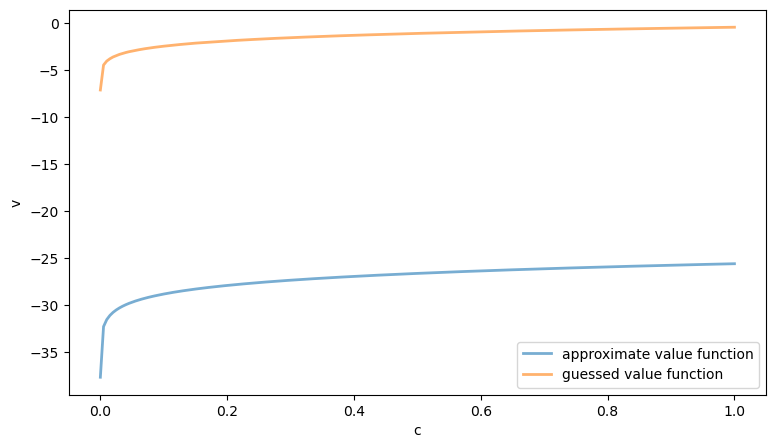

In [33]:
#==============================================================================
# Plotting value function
#==============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(grid, value_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, guess_w, lw=2, alpha=0.6, label='guessed value function')
ax.set_xlabel('c')
ax.set_ylabel('v')
ax.legend(loc='lower right')
plt.show()

The figure above compares our initial guess with the approximated value function resulting from the arbitrary policy.

### Policy Iteration

We can combine policy evaluation with policy improvement to evaluate the value function generated by the optimal policy.

![Untitled](_images/Policy_Iteration.png)

We now provide an illustration of this approach for the optimal growth model.

In [40]:
#==============================================================================
# Optimal Growth: Policy Iteration
#==============================================================================

def evaluation_policy(w, pol, grid, β, u, f):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    Tw = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c))} == #
    for i, y in enumerate(grid):
        Tw[i] = u(pol[i])+β * w_func(f(y - pol[i]))

    return Tw

def improve_policy(w, grid, β, u, f, Tw=None):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    Tpolicy = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c))} == #
    for i, y in enumerate(grid):
        def objective(c, y=y):
            return - u(c) - β * w_func(f(y - c))
        c_star = fminbound(objective, 1e-10, y)
        
        Tpolicy[i] = c_star 

        Tw[i] = - objective(c_star)

    return Tw, Tpolicy

def solve_optgrowth_policy(initial_w, pol, grid, β, u, f, tol=1e-4, max_iter=500):
    w = np.empty(len(grid))
    w[:] = initial_w  # Set initial condition
   
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory
    # allocation and speeds code up == #
    Tw = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = evaluation_policy(w,
                                 pol,
                                 grid,
                                 β,
                                 u,
                                 f)
        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1
    
    return [w]

# Policy function to be evaluated
policy  = .5*grid 

# Initial guess for the value function
guess_w  = ces.u(policy)

We provide below an example of how to compute the value function resulting from the conjectured policy, and then store in `solve_improve` the improved policy associated to the new value function.

In [41]:
# Computation of the initial value function
solve = solve_optgrowth_policy(guess_w, policy, grid, β, u=ces.u,
                               f=ces.f, tol=1e-4, max_iter=500)
value_approx = solve[0]

# Computation of the updated policy function
solve_improve = improve_policy(value_approx, grid, β, u=ces.u, f=ces.f)

Repeating the steps above iteratively until convergence allows us to approximate the true value function and optimal policy.

In [42]:
# Iterated procedure
tol=1e-4
error = tol + 1
i = 0
max_iter=500
w=np.empty(len(grid))
w[:] = guess_w
w_history = [] 

while error > tol and i < max_iter:
    solve_eval = solve_optgrowth_policy(w, policy, grid, β, u=ces.u,
                                f=ces.f, tol=1e-4, max_iter=500)
    w_approx = solve_eval[0]
    solve_improve = improve_policy(w_approx, grid, β, u=ces.u, f=ces.f, Tw=None)
    w_new = solve_improve[0]
    policy_new=solve_improve[1]
    error = np.max(np.abs(policy_new - policy))
    policy[:] = policy_new
    w[:] = w_new
    w_history.append(w.copy())  # Append a copy of w to the list
    i += 1
    print("Iteration "+str(i)+'\n Error is '+str(error)+'\n')

value_final = w_new

Iteration 1
 Error is 0.1310681176524393

Iteration 2
 Error is 0.0061036722306999636

Iteration 3
 Error is 0.0015584785903355325

Iteration 4
 Error is 9.152334480444502e-05



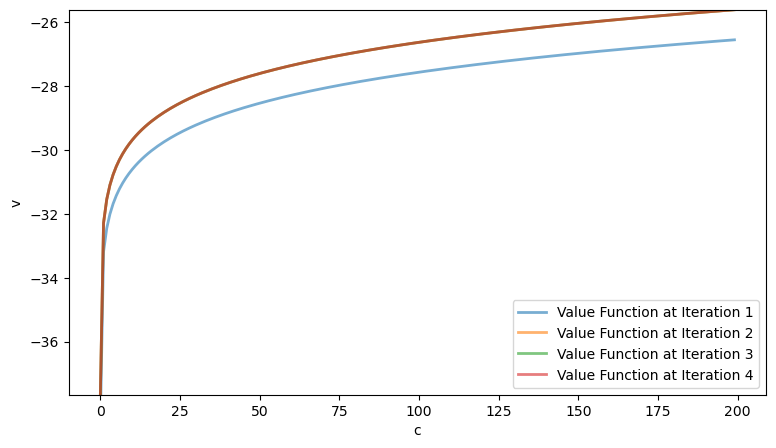

In [43]:
#==============================================================================
# Plotting value functions
#==============================================================================

w_matrix = np.array(w_history)  # Convert the list to a matrix

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(value_final), max(value_final))
for i in range(w_matrix.shape[0]):
    ax.plot(w_matrix[i], lw=2, alpha=0.6, label='Value Function at Iteration '+str(i+1))
ax.set_xlabel('c')
ax.set_ylabel('v')
ax.legend(loc='lower right')
plt.show()

The figure above shows the value functions at each iteration. Note that the total number of iterations is significantly smaller than in the nested procedure, where the value and policy functions are updated simultaneously.

## Reinforcement Learning

[This repository](https://github.com/AntonioSerrano/Implementation-of-RL-algorithms-from-Sutton-and-Barto-2018) provides code, exercises and solutions from

- [Reinforcement Learning: An Introduction (2nd Edition)](http://incompleteideas.net/book/RLbook2018.pdf)

Each folder in [the repository](https://github.com/AntonioSerrano/Implementation-of-RL-algorithms-from-Sutton-and-Barto-2018) corresponds to one or more chapters of the above textbook and/or course. In addition to exercises and solution, each folder also contains a list of learning goals, a brief concept summary, and links to the relevant readings.

All code is written in Python 3 and uses RL environments from [OpenAI Gym](https://gym.openai.com/). Advanced techniques use [Tensorflow](https://www.tensorflow.org/) for neural network implementations.